In [1]:
################################################################################
######################### Import Necessary Modules #############################
################################################################################

import numpy as np
import os
import sys
%matplotlib nbagg
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

import subprocess
import pickle
import gzip
import os
import cProfile
import pstats

matplotlib.usetex = 1

from scipy import fftpack
from scipy import misc
from scipy import ndimage

from schrodinger import Schrodinger  #This is the solver that does all the work

################################################################################
######################### Gaussian wave-packet #################################
################################################################################

def gaussian_wavepacket(t, x, a, h, m, x0, p0):
    A = np.pi**(-1/4.)
    beta =  (1 + 1j*(h*t)/(m*a**2))
    E = p0**2/(2*m)
    phase = np.exp(1j*(p0*x - E*t)/h)
    return ((A/np.sqrt(a*beta))*phase*np.exp(-(x - x0 - (p0/m)*t)**2/(2*a**2*beta)))

def inverse_parabola_wavepacket(t, x, a, h, m, x0, p0, c):
    const = (2*c*np.sqrt(2*m))/h**2
    scaledT = (const)**(-1)*(1-np.exp(-const*t))
    scaledX = x*np.exp(-c*np.sqrt(2*m)*t/h**2)
    phase = np.exp((1j*np.sqrt(2*m)*c*x**2)/(2*h))
    scale = np.exp(-c*t/np.sqrt(2*m))
    return gaussian_wavepacket(scaledT, scaledX, a, h, m, x0, p0)*phase*scale

def squared_wavefunction(t, x, a, h, m, x0, p0):
    beta = 1 + 1j*(h*t)/(m*a**2)
    return (1/((np.pi)**(1/2.)*a*abs(beta))*
                np.exp(-(x - x0 - (p0/m)*t)**2/(a**2 * abs(beta**2))))

################################################################################
######################### Analytic Dispersions #################################
################################################################################

def free_particle_dispersion(t, a, h, m):
    return (a/np.sqrt(2))*np.sqrt(1 + (h*t/(m*a**2))**2)

def parabolic_dispersion_Hagedorn(t, a, c):
    return  (1/np.sqrt(2))*t*a*np.cosh(2*c*t)

def ExtremalCharacteristics(t, alpha):
    const = ((1-alpha)**2/(2*(1+alpha)))**(1/(1-alpha))
    exponent = (2/(1-alpha))
    return const*t**exponent, - constant0*t**exponent

################################################################################
######################### Fractional Brownian Potential ########################
################################################################################

def derivative(x, mu):
    n = len(x)
    xx = np.append( np.append(
                (x[1:n/2+1][::-1]), x ),
                 x[-n/2-1:-1][::-1] ) # boundaries
    nn = 2 * n
    xft = np.fft.fft(xx)
    omega = np.fft.fftfreq(nn, d = 1./n) * 2 *np.pi 
    y = np.nan_to_num(( omega * 1j) ** mu)
    y[0] = 0.
    dxdt = np.real(np.fft.ifft( y * xft ))
    dxdt = dxdt[n/2:-n/2]
    return dxdt
  
def fbm(n = 1e5, 
        H = 1.3, 
        rseed = None):
    mu = 0.5 - H
    np.random.seed(rseed)
    x = derivative( np.random.randn(n), mu)
    x -= x.mean()
    y = derivative(x/x.std(), -1.)
    y -= np.mean(y)
    return y/y.std()

def SmoothedBrownianPotential(ell, 
                              n = 1e5, 
                              H = 1.3, 
                              rseed = None):
    bla = fbm(n, H = H, rseed = rseed)
    return ndimage.gaussian_filter(bla, ell)

################################################################################
############################### Cusp Potential #################################
################################################################################

def LocalizedSmoothConicalPotential(ell,
                                    x, 
                                    e = 1.3, 
                                    zero = 15):
    v = zero**e
    ConicalPotential = .5*((1./v)*(v - np.abs(x)**(e)))
    bumpfunction = np.piecewise(x, [abs(x) < zero, abs(x) >= zero], [1, 0])
    return  ndimage.gaussian_filter(ConicalPotential*bumpfunction, ell)  
        

/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:79: RuntimeWarning: invalid value encountered in power
/Users/tdrivas/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:79: RuntimeWarning: invalid value encountered in reciprocal


<IPython.core.display.Javascript object>


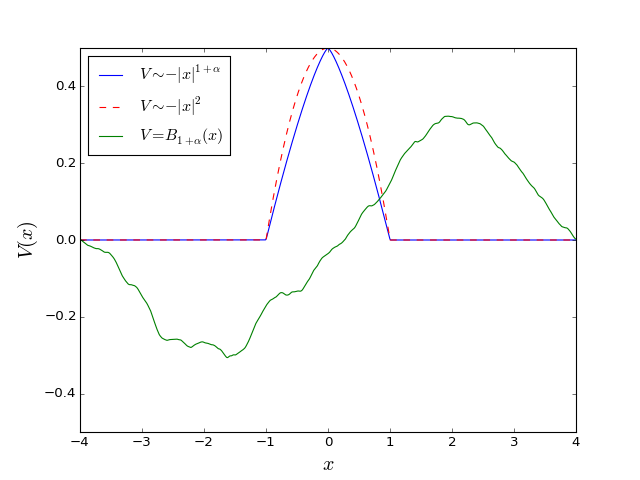

In [2]:
################################################################################
############################### Plots Potentials ###############################
################################################################################

def PlotPotential(Vpara = None,
                  Vcusp = None,
                  Vfbm = None,
                  xmax = 10):
    xfine = np.arange(-xmax, xmax, 2.*xmax/Vfbm.shape[0]).astype(np.float)
    maximum =  max(np.max(abs(Vpara)), np.max(abs(Vcusp)), np.max(abs(Vfbm)))
    ax = plt.figure().add_subplot(111)
    ax.plot(xfine,
            Vcusp,'b-',
            label = '$V\\sim -|x|^{1+ \\alpha}$')
    ax.plot(xfine,
            Vpara,'r--',
            label = '$V\\sim -|x|^{2}$')
    ax.plot(xfine,
            Vfbm,'g',
            label = '$V = B_{1+\\alpha}(x)$')
    ax.legend(loc = "best")
    ax.set_xlim(-xmax, xmax)
    ax.set_ylim(-maximum, maximum)
    ax.set_xlabel('$x$', fontsize = 18)
    ax.set_ylabel('$V(x)$', fontsize = 18)

ell = 100
n = 1e5
e = 1.3
xmax = 4

Vfbm =  0.2*SmoothedBrownianPotential(ell, n, e, rseed = 11)
xfine = np.arange(-xmax, xmax, 2.*xmax/Vfbm.shape[0]).astype(np.float)
Vpara =  LocalizedSmoothConicalPotential(0, xfine, 2, zero = 1)
Vcusp = LocalizedSmoothConicalPotential(ell, xfine, e, zero = 1)
PlotPotential(Vpara = Vpara,
              Vcusp = Vcusp,
              Vfbm = Vfbm,
              xmax = xmax)

Solving Schroedinger
-----

We supply the Schoedinger equation with initial data in the form of a minimal uncertainty wavepacket
$$\psi_0(x;x_0) = \frac{1}{(2\pi)^{1/4}\sigma^{1/2}}\exp\left(-\frac{|x-x_0|^2}{4\sigma^2}\right)e^{i p_0x/\hbar}$$
Note that since $\hat{p}= \hbar/i \partial_x$, we have that $\hat{p}\psi_0(x) = (p_0+ i\hbar x/\sigma^2 )\psi_0(x)$. As "$\hbar\to0$" this corresponds to fixing an initial moment for the "classical particle".


Roughly speaking, this solver uses a split physical-fourier space method.  That is first it solves 
$
i \hbar \partial_t \psi = V\psi 
$
yielding 
$
\psi(x, t+\Delta t) = \psi(x,t)e^{-iV(x) \Delta t/\hbar}.
$

Then, on the fourier side it solve 
$
i \hbar \partial_t \hat{\psi} = \frac{\hbar^2k^2}{2m}\hat{\psi} 
$
yeilding 
$
\hat{\psi}(k, t+\Delta t) = \hat{\psi}(k,t)e^{-i\hbar^2k^2 \Delta t/2m}.
$

Here are more details on algorithm that it uses

1) Discretize wavefunction to a grid $\psi_n(t)= \psi(x_n,t)$, $V_n= V(x_n)$ and $\hat{\psi}_m= \hat{\psi}(k_n,t)$.

2)  Progress the system by step $\Delta t$.  This involves first computing a "half step" in $x$:
$
x: \psi_n \leftarrow \psi_ne^{-iV(x) (\Delta t/2)/\hbar}
$

3) The calculate $\hat{\psi}_m$ from $\psi_n$ via FFT

4)  Computing a "full step" in $k$:
$
k: \hat{\psi}_m \leftarrow \hat{\psi}_m e^{-i\hbar^2k^2 \Delta t/2m}
$

5) Calculate $\psi_n$ from $\hat{\psi}_m$ via inverse FFT

6) Compute second "half-step" in $x$
$
\psi_n \leftarrow \psi_ne^{-iV(x) (\Delta t/2)/\hbar}
$

7) Repeat



In [6]:
class GetData:
    def __init__(self,
                 nsteps = 20,
                 resolution = 2**6,
                 timestep = 1.,
                 hbar = 1., 
                 xmax =  2.**6*np.pi):
        self.nsteps = nsteps
        self.resolution = resolution
        self.timestep = 1.
        self.hbar = float(hbar)
        self.sigma = self.hbar**(0.5) 
        self.ell = self.hbar 
        self.dx = np.pi * self.hbar / self.resolution
#        if self.dx / self.ell > 0.1:
#            print ('dx/ell = {0} for hbar = {1}'.format(self.dx/self.ell, self.hbar))
#            self.dx = 0.1*self.ell
        dt = self.hbar/(2*self.resolution)
        self.nsubsteps = int(self.timestep / dt)
        self.x = (self.dx*np.arange(
                      1,
                      2**(int(np.log2(xmax/self.dx)) + 1) + 1).astype(np.float) -
                  xmax)
        self.x0 = 0.0
        self.p0 = 0.0
        self.m  = 1.0
        self.psi_x0 = gaussian_wavepacket(0,
                                          self.x,
                                          self.sigma,
                                          self.hbar,
                                          self.m,
                                          self.x0,
                                          self.p0)
        self.sol = {}
        return None
    def compute(self,
                base_name = None,
                V = None,
                base_info = {}):
        self.sol[base_name] = Schrodinger(
                x = self.x,
                psi_x0 = self.psi_x0,
                V_x = V,
                hbar = self.hbar,
                m = self.m)
        self.sol[base_name].evolve(
            self.nsteps,
            self.nsubsteps,
            self.timestep/self.nsubsteps,
            base_name = base_name,
            base_info = base_info)
        return self.sol[base_name]
    
class read_solution:
    def __init__(
            self,
            base_name = None):
        if type(base_name) != type(None):
            if os.path.isfile(base_name + '_psi_x_full.npy'):
                self.psi_x_full = np.load(
                    base_name + '_psi_x_full.npy')
                self.time = np.load(base_name + '_t.npy')
                self.x    = np.load(base_name + '_x.npy')
                self.dx = self.x[1] - self.x[0]
                self.k    = np.load(base_name + '_k.npy')
                self.V_x  = np.load(base_name + '_V.npy')
                self.dispersion_vs_t = \
                    np.sqrt(np.sum((np.abs(self.psi_x_full)**2)*self.x**2*self.dx, axis = 1) -
                            np.sum((np.abs(self.psi_x_full)**2)*self.x*self.dx, axis = 1)**2)
        return None

<IPython.core.display.Javascript object>


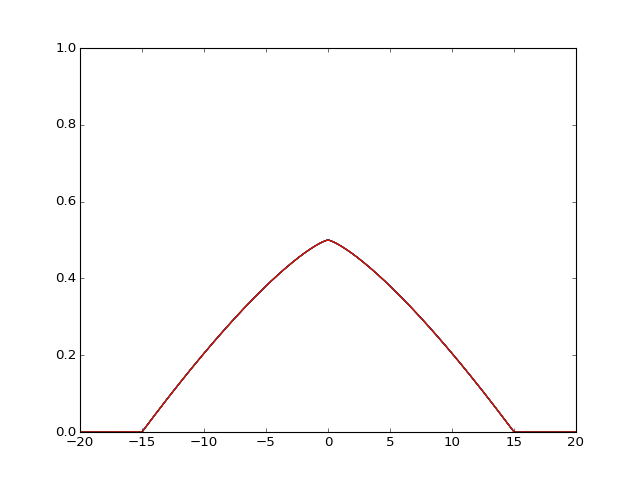

In [7]:
hlist = 2.**(-np.arange(0, 10))
a = plt.figure().add_subplot(111)
for h in hlist:
    c = GetData(resolution = 2**6, hbar = h)
    a.plot(c.x, LocalizedSmoothConicalPotential(c.ell, c.x, 1.3, 15))
    a.set_xlim(-20, 20)
    a.set_ylim(0, 1)

In [58]:
storedData = []

hbarUsed = 2.**(-np.arange(0, 4, 1))

#hbarUsed = np.array([2**(-1), 2**(-3), 2**(-5), 2**(-7), 2**(-9)])
#hbarUsed = np.array([2**(-9)])


def main():
    computator = [GetData(
                      nsteps = 30,
                      resolution = 2**6,
                      hbar = h)
                  for h in hbarUsed]
    for c in computator:
        print('computing for h = {0}'.format(c.hbar))
        suffix = '_{0}_res_{1}'.format(c.hbar, c.resolution)
        storedData.append(
            (c.compute(base_name = 'data/Scone' + suffix,
                       V = LocalizedSmoothConicalPotential(
                               c.ell, c.x, 1.3, 15),
                       base_info = {'roughness' : 1.3,
                                    'ell' : c.ell}),
             c.compute(base_name = 'data/Spara' + suffix,
                       V = LocalizedSmoothConicalPotential(
                               0.0, c.x, 2, 15),
                       base_info = {'roughness' : 2})))

cProfile.run('main()', 'profile')
p = pstats.Stats('profile')
p.sort_stats('cumulative').print_stats(10)
p.sort_stats('time').print_stats(10)

computing for h = 1.0
at step 1 of 30
at step 2 of 30
at step 3 of 30
at step 4 of 30
at step 5 of 30
at step 6 of 30
at step 7 of 30
at step 8 of 30
at step 9 of 30
at step 10 of 30
at step 11 of 30
at step 12 of 30
at step 13 of 30
at step 14 of 30
at step 15 of 30
at step 16 of 30
at step 17 of 30
at step 18 of 30
at step 19 of 30
at step 20 of 30
at step 21 of 30
at step 22 of 30
at step 23 of 30
at step 24 of 30
at step 25 of 30
at step 26 of 30
at step 27 of 30
at step 28 of 30
at step 29 of 30
at step 30 of 30
at step 1 of 30
at step 2 of 30
at step 3 of 30
at step 4 of 30
at step 5 of 30
at step 6 of 30
at step 7 of 30
at step 8 of 30
at step 9 of 30
at step 10 of 30
at step 11 of 30
at step 12 of 30
at step 13 of 30
at step 14 of 30
at step 15 of 30
at step 16 of 30
at step 17 of 30
at step 18 of 30
at step 19 of 30
at step 20 of 30
at step 21 of 30
at step 22 of 30
at step 23 of 30
at step 24 of 30
at step 25 of 30
at step 26 of 30
at step 27 of 30
at step 28 of 30
at step 29

<pstats.Stats instance at 0x14fdbaf80>

In [60]:
 for d in storedData:
     print d[0].hbar == d[1].hbar
     print [d[i].x.shape for i in range(2)]
     print [d[i].dispersion_vs_t[-1] for i in range(2)]

#print dir(schrodinger)

True
[(8192,), (8192,)]
[nan, nan]
True
[(16384,), (16384,)]
[nan, nan]
True
[(32768,), (32768,)]
[nan, nan]
True
[(65536,), (65536,)]
[nan, nan]


Wavefunction Measurement and Dispersion
---

In the case of a free Gaussian wavepacket, we can solve Schroedinger's equation analytically.  The result is the following
\begin{equation}
\psi(x,t) = \frac{1}{\pi^{1/4}\sqrt{\sigma\beta(t)}} e^{i(p_0x-E(p_0)t)/\hbar} e^{-[x-x_0-(p_0/m)t]^2/(2\sigma^2\beta(t))}
\end{equation}
where $\beta(t)= 1 + i\frac{\hbar t}{m \sigma^2}$ and $E(p_0)= p_0^2/2m$. Showing our evolution of a free wavepacket agrees with the analytic form will be a check on our code.  The analytic form for the dispersion for this free wave packet is
\begin{equation}
\Delta x(t) = \frac{\sigma}{\sqrt{2}} \sqrt{1 + \left(\frac{\hbar t}{m \sigma^2}\right)^2}
\end{equation}
On the other hand, for a particle moving in a parabolic potential, the dispersion in the semiclassical limit may be computed analytically via Hagedorn's equations.  This reads
\begin{equation}
\Delta x(t) = \frac{t \sigma}{\sqrt{2}} \cosh(c t)
\end{equation}
where $c$ is (twice) constant in front of the $x^2$ term in of the parabola.

In [55]:
def snapshop_wavefunction(
        tf = 20,
        data = storedData[0],
        minx = -20,
        maxx = 20,
        yheight = 20,
        prefix = 'bla'):
    h = data[0].hbar
    a = np.sqrt(h)
    
    time = np.arange(0, data[0].dispersion_vs_t.shape[0]).astype(np.float)
    
    lineardispersion = free_particle_dispersion(time, a, h, 1)

    fig = plt.figure(figsize=(10, 4))
    axw = fig.add_subplot(121)
    axd = fig.add_subplot(122)
    for observation_time in range(tf):
        axw.cla()
        axd.cla()
        axw.plot(data[0].x,
                 np.abs(data[0].psi_x_full[observation_time])**2,'b-',
                 color = 'blue')
        axw.plot(data[0].x,
                 squared_wavefunction(observation_time, data[0].x, a, h, 1, 0, 0),'r--',
                 #label = '$V = 0 \ {\\rm analytic}$',
                 color = 'red')
        axw.plot(data[1].x,
                 np.abs(data[1].psi_x_full[observation_time])**2,'b-',
                 color = 'green')
        axw.plot(data[0].x, 
                 data[0].V_x - 0.45,
                 color = 'black')
        axw.set_title("$\\hbar$ = {0}".format(h))
        axw.legend(loc = "best")
        axw.set_xlim(minx, maxx)
        axw.set_ylim(0, .1)
        axw.set_xlabel('$x$', fontsize = 18)
        axw.set_ylabel('$\\psi_t^*\\psi_t$', fontsize = 18)

        axd.plot(time[:observation_time+1],
                data[0].dispersion_vs_t[:observation_time+1],
                label = '$V\\sim -|x|^{(1+ \\alpha)}$',
                color = 'blue')
        axd.plot(time[:observation_time+1],
                data[1].dispersion_vs_t[:observation_time+1],
                label = '$V\\sim -|x|^2$',
                color = 'green')
        axd.plot(time[:observation_time+1],
                lineardispersion[:observation_time+1],
                label = '$V = 0$',
                color = 'cyan')
        axd.plot(time, lineardispersion,'--',  color = 'red')
        axd.set_title("$\\hbar$ = {0}".format(h))
        axd.set_xlim(0, tf)
        axd.set_ylim(0, yheight)
        axd.legend(loc = "best")
        axd.set_xlabel('$t$', fontsize = 18)
        axd.set_ylabel('$|\\Delta(t)|^2$', fontsize = 18)
        fig.savefig('figs/' + prefix + '_frame_{0:0>2}.png'.format(observation_time),
                    format = 'png')
    subprocess.call(['convert', 'figs/' + prefix + '_frame*.png', prefix + '.gif'])

#### We calculate the dispersion of the wavefuntion $\psi(t)$ in the following way: \begin{equation} \Delta_{\psi}(t) = \left(\int_{\mathbb{R}} \psi(t)^* x^2\psi(t) {\rm d} x - \left|\int_{\mathbb{R}} \psi(t)^* x \psi(t) {\rm d} x \right|^2 \right)^{1/2} \end{equation}

<IPython.core.display.Javascript object>


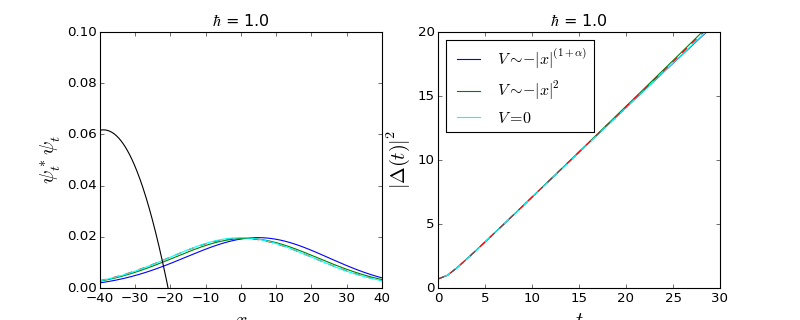

<IPython.core.display.Javascript object>


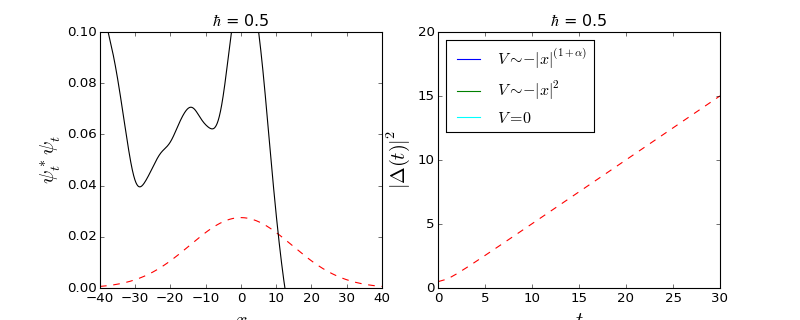

<IPython.core.display.Javascript object>


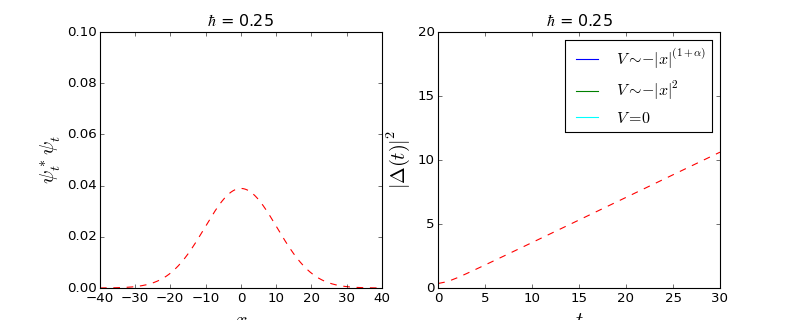

In [94]:
def plotResults(T = 30, domainsize = 40, yH = 20):
    for i in range(len(storedData)):
        snapshop_wavefunction(prefix = 'Evolution_for_hbar_{0}'.format(hbarUsed[i]),
                              tf = T,
                              data = storedData[i],
                              minx = -domainsize,
                              maxx = domainsize,
                              yheight = yH)
    return None
plotResults()

<IPython.core.display.Javascript object>


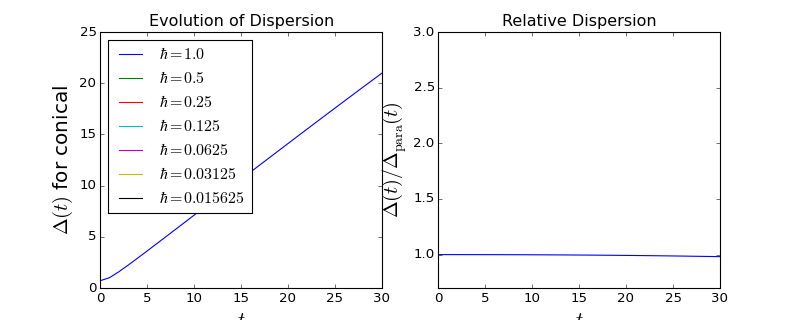

<IPython.core.display.Javascript object>


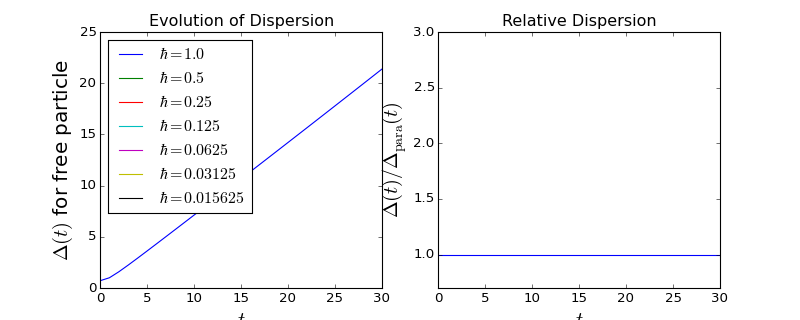

<IPython.core.display.Javascript object>


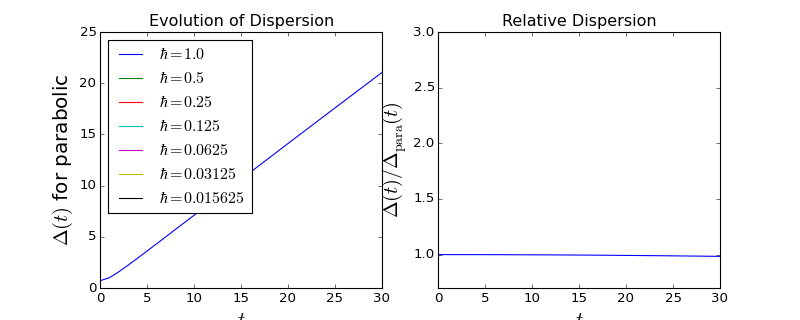

In [82]:
def dispersionMultipleH(tf = 20, yH = 20):
    time = np.arange(0, storedData[0][0].dispersion_vs_t.shape[0]).astype(np.float)
    labels = ['conical','free particle', 'parabolic']
    #fig = plt.figure(figsize=(12, 12))
    for j in range(3):
        #ax = fig.add_subplot(22{0}).format(j+1)
        fig = plt.figure(figsize=(10, 4))
        for i in range(len(storedData)):
            ax = fig.add_subplot(121)
            ax.plot(time,
                    storedData[i][j].dispersion_vs_t,
                    label = '$\hbar = {0}$'.format(storedData[i][1].hbar))
            ax.set_xlim(0, tf)
            ax.set_ylim(0, yH)
            ax.legend(loc = "best")
            ax.set_xlabel('$t$', fontsize = 18)
            ax.set_ylabel('$\\Delta(t)$ for {0}'.format(labels[j]), fontsize = 18)
            ax.set_title("Evolution of Dispersion")
            
            ax = fig.add_subplot(122)
            ax.plot(time,
                    storedData[i][j].dispersion_vs_t/storedData[i][1].dispersion_vs_t)
            ax.set_xlim(0, tf)
            ax.set_ylim(.7, 3)
            ax.legend(loc = "best")
            ax.set_xlabel('$t$', fontsize = 18)
            ax.set_ylabel('$\\Delta(t)/\\Delta_{{\\rm para}}(t)$', fontsize = 18)
            ax.set_title("Relative Dispersion")
            #plt.gcf().savefig('dispersionStudy{0}.pdf'.format(j), format = 'pdf')
    return None
dispersionMultipleH(tf = 30, yH = 25)

<IPython.core.display.Javascript object>


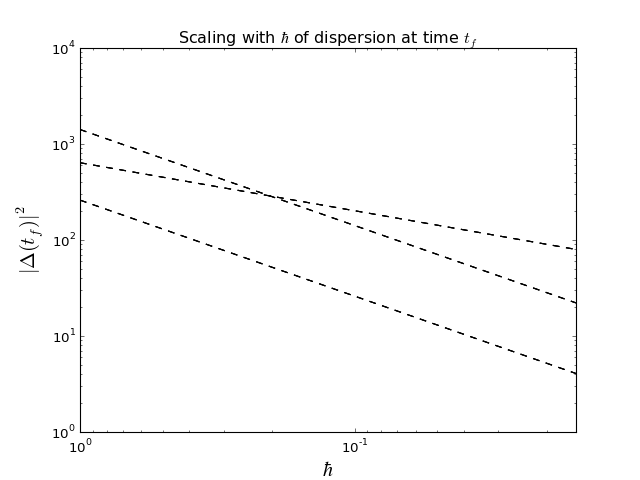

In [83]:
def dispersionFunctionOfHbar(tf = 30):
    finaltimedispersion =  [[0 for i in range(len(storedData))] for i in range(3)]
    for i in range(len(storedData)):
        finaltimedispersion[0][i] = (storedData[i][0].dispersion_vs_t[tf])**2
        finaltimedispersion[1][i] = (storedData[i][1].dispersion_vs_t[tf])**2
        finaltimedispersion[2][i] = (storedData[i][2].dispersion_vs_t[tf])**2
    ax = plt.figure().add_subplot(111)
    for j in range(len(finaltimedispersion)):
        ax.plot(hbarUsed,
                finaltimedispersion[j])
        ax.plot(hbarUsed,
                hbarUsed*finaltimedispersion[1][0]*0.57, '--k')
        ax.plot(hbarUsed,
                hbarUsed*finaltimedispersion[2][0]*3.2, '--k')
        ax.plot(hbarUsed,
                hbarUsed**(0.5)*finaltimedispersion[0][0]*1.45, '--k')
        ax.set_xlim(0, 1)
        #ax.set_ylim(0, 800)
        ax.legend(loc = "best")
        ax.set_xlim(ax.get_xlim()[::-1])
        ax.set_xscale('log')
        ax.set_xlabel('$\\hbar$', fontsize = 18)
        ax.set_ylabel('$|\\Delta(t_f)|^2$', fontsize = 18)
        ax.set_yscale('log')
        ax.set_title("Scaling with $\\hbar$ of dispersion at time $t_f$")
        #plt.gcf().savefig('hbar_scaling.pdf', format = 'pdf')
    return None
dispersionFunctionOfHbar(tf = 30)

In [56]:
def Probability(t = 30):
    ProbCone = [0 for i in range(len(storedData))]
    ProbPara = [0 for i in range(len(storedData))]
    ProbFree = [0 for i in range(len(storedData))]
    for i in range(len(storedData)):
        ProbCone[i] = np.sum((np.abs(storedData[i][0].psi_x_full[t])**2)*storedData[i][0].dx)
        ProbPara[i] = np.sum((np.abs(storedData[i][1].psi_x_full[t])**2)*storedData[i][1].dx)
        ProbFree[i] = np.sum((np.abs(storedData[i][2].psi_x_full[t])**2)*storedData[i][2].dx)
    return ProbCone, ProbPara, ProbFree
Probability(t = 0)

IndexError: tuple index out of range

In [ ]:
hbarUsed = np.array([2**(0), 2**(-1), 2**(-2), 2**(-3), 2**(-4), 2**(-5), 2**(-6), 2**(-7), 2**(-8), 2**(-9)])

def get_dispersion_vs_h(
        hlist = [],
        prefix = 'Scone'):
    d = []
    for h in hlist:
        suffix = '_{0}_res_{1}'.format(h, 2**6)
        print ('reading data for ' + prefix + suffix)
        c = read_solution(base_name = 'data/' + prefix + suffix)
        d.append(c.dispersion_vs_t[20])
    return np.array(d)

dcone = get_dispersion_vs_h(hlist = hbarUsed,
                            prefix = 'Scone')
dfree = get_dispersion_vs_h(hlist = hbarUsed,
                            prefix = 'Sfree')
dpara = get_dispersion_vs_h(hlist = hbarUsed,
                            prefix = 'Spara')


ax = plt.figure().add_subplot(111)
ax.plot(hbarUsed, dcone)
ax.plot(hbarUsed, dfree)
ax.plot(hbarUsed, dpara)
ax.plot(hbarUsed, hbarUsed**(-1))
# ax.plot(hbarUsed, hbarUsed**(-0.5))
# ax.set_xlim(0, 1)
# #ax.set_ylim(0, 800)
# ax.legend(loc = "best")
# ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xscale('log')
# ax.set_xlabel('$\\hbar$', fontsize = 18)
# ax.set_ylabel('$|\\Delta(t_f)|^2$', fontsize = 18)
ax.set_yscale('log')
# ax.set_title("Scaling with $\\hbar$ of dispersion at time $t_f$")